In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [2]:
time_step=30

In [3]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()
    return fix_df

In [4]:
# 补全缺失数据
def fix_zero(df,index):
    df[index]=df[index].replace(0.00, np.NaN)
    df[index]=df[index].fillna(df[index].median())
    return df

In [5]:
# 读取数据
his_nmp_gf_df = pd.read_csv('.\\data\\GF001\\03 His_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('.\\data\\GF001\\02 His_Power_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据

In [6]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])

In [7]:
df=fix_zero(df,'Humidity')

In [8]:
df_feaformm=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
df_feaformm["Power(MW)"]=np.NaN
df_feaformm=fix_zero(df_feaformm,'Humidity')

In [9]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df))-time_step:int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df))-time_step:]

In [10]:
gf_df_test.shape

(165, 7)

In [11]:
gf_df_test_copy=gf_df_test.copy()


In [12]:
# 定义一个新的归一化函数
def simla(stand_df,df):
    train_median1=stand_df['Irradiance'].median()
#     print('Irradiance',train_median1)
    train_median2=stand_df['Speed10'].median()
#     print('Speed10',train_median2)
    train_median3=stand_df['Direction10'].median()
#     print('Direction10',train_median3)
    train_median4=stand_df['Temper'].median()
#     print('Temper',train_median4)
    train_median6=stand_df['Humidity'].median()
#     print('Humidity',train_median6)
    train_median5=stand_df['Pressure'].median()
#     print('Pressure',train_median5)
    train_median7=stand_df['Power(MW)'].median()
#     print('Power(MW)',train_median7)
    df_copy=df.copy()
    df_copy['Irradiance']=df['Irradiance']/train_median1
    df_copy['Speed10']=df['Speed10']/train_median2
    df_copy['Direction10']=df['Direction10']/train_median3
    df_copy['Temper']=df['Temper']/train_median4
    df_copy['Humidity']=df['Humidity']/train_median6
    df_copy['Pressure']=df['Pressure']/train_median5
    df_copy['Power(MW)']=df['Power(MW)']/33
    return df_copy

In [13]:
# 定义一个反归一化函数
def Denormalization(stand_df,df):
    train_median=stand_df['Power(MW)'].median()
#     print('Power(MW)',train_median)
    df_copy=df.copy()
    df_copy=df*33
    return df_copy

In [14]:
df_for_training_scaled = simla(df,gf_df_train).values
df_for_validing_scaled=simla(df,gf_df_valid).values
df_for_testing_scaled=simla(df,gf_df_test).values

In [15]:
# 分离x与y
def createXY(array, days_used_to_train=30):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

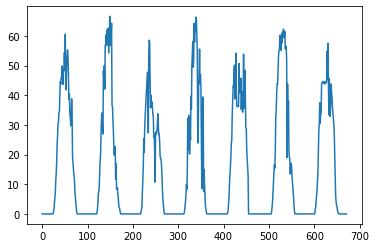

In [16]:
# 看一下历史波形
plt.plot(range(len(df['Power(MW)'])), df['Power(MW)'], label='history')

In [17]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [18]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=size))
#     grid_model.add(tf.keras.layers.Flatten())
#     grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
#     grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(1))
    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    return grid_model

In [19]:
# 准备一些copy用用
df_for_testing_scaled_forpred=df_for_testing_scaled.copy()
df_for_testing_scaled_inloop=df_for_testing_scaled.copy()

df_for_testing_scaled_forpred=pd.DataFrame(df_for_testing_scaled_forpred)
df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)

df_for_testing_scaled_forpred_array=df_for_testing_scaled_forpred.values
df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values

df_for_testing_scaled_inloop.iloc[time_step:,-1]=np.nan

In [20]:
# 准备一些copy用用
df_for_validing_scaled_forpred=df_for_validing_scaled.copy()
df_for_validing_scaled_inloop=df_for_validing_scaled.copy()

df_for_validing_scaled_forpred=pd.DataFrame(df_for_validing_scaled_forpred)
df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)

df_for_validing_scaled_forpred_array=df_for_validing_scaled_forpred.values
df_for_validing_scaled_inloop_array=df_for_validing_scaled_inloop.values

df_for_validing_scaled_inloop.iloc[time_step:,-1]=np.nan

In [21]:
df_for_testing_scaled_inloop.to_csv('df_for_testing_scaled_inloop.csv',encoding = 'utf-8') #存储合并后数据

In [22]:
# 为循环初始化一些数据
bestscore=1000
idealscore=20
flag=0
num=0
best_size=0
best_batch_size=0
best_epochs=0
time_step=30
df_liner=pd.read_csv('df_liner.csv')
df_liner_size=[]
df_liner_batch_size=[]
df_liner_epochs=[]
df_liner_score=[]
num_loop=0 #记录while_loop次数

In [23]:
# 初始化参数
size_score=0
size_begin=4
size_end=8
size_step=(size_end-size_begin)//2

In [24]:
# 初始化参数
batch_size_score=0
batch_size_begin=7
batch_size_end=8
batch_size_step=(batch_size_end-batch_size_begin)//1

In [25]:
# 初始化参数
epochs_score=0
epochs_begin=10
epochs_end=20
epochs_step=(epochs_end-epochs_begin)//2

In [26]:
df_liner_size

[]

In [27]:
df_liner['size']

Series([], Name: size, dtype: object)

In [28]:
while bestscore>=idealscore:
    
    #清空数据表
    df_liner_size=[]
    df_liner_batch_size=[]
    df_liner_epochs=[]
    df_liner_score=[]
    
    df_liner=pd.read_csv('df_liner.csv')
    df_liner['size']=df_liner_size
    df_liner['batch_size']=df_liner_batch_size
    df_liner['epochs']=df_liner_epochs
    df_liner['score']=df_liner_score
    
    #更新range范围
    if num_loop>0:
        size_score=reg.coef_[0]
        if size_score==0:
            size_begin=size_begin
            size_end=size_end
        elif size_score>0:
                size_begin=size_begin//2
                size_end=size_end//2
        elif size_score<0:
                size_begin=size_begin*2
                size_end=size_end*2
        size_step=(size_end-size_begin)//2
        if size_step<=0:
            size_step=1

        batch_size_score=reg.coef_[1]
        if batch_size_score==0:
            batch_size_begin=batch_size_begin
            batch_size_end=batch_size_end
        elif batch_size_score>0:
            batch_size_begin=batch_size_begin//2
            batch_size_end=batch_size_end//2
        elif batch_size_score<0:
            batch_size_begin=batch_size_begin*2
            batch_size_end=batch_size_end*2
        batch_size_step=(batch_size_end-batch_size_begin)//2
        if batch_size_step<=0:
            batch_size_step=1

        epochs_score==reg.coef_[2]
        if epochs_score==0:
            epochs_begin=epochs_begin
            epochs_end=epochs_end
        elif epochs_score>0:
            epochs_begin=epochs_begin//2
            epochs_end=epochs_end//2
        elif epochs_score<0:
            epochs_begin=epochs_begin*2
            epochs_end=epochs_end*2
        epochs_step=(epochs_end-epochs_begin)//2
        if epochs_step<=0:
            epochs_step=1
            
    print('num_loop:',num_loop)       
    print('size||','start:',size_begin,'end:',size_end,'step:',size_step)
    print('batch_size||','start:',batch_size_begin,'end:',batch_size_end,'step:',batch_size_step)
    print('epochs||','start:',epochs_begin,'end:',epochs_end,'step:',epochs_step)

            
            
        
    # 开始循环（warning不影响做）
    for size in range(size_begin,size_end,size_step):
        for batch_size in range(batch_size_begin,batch_size_end,batch_size_step):
            for epochs in range(epochs_begin,epochs_end,epochs_step):
                df_liner_size.append(size)
                df_liner_epochs.append(epochs)
                df_liner_batch_size.append(batch_size)
    #             df_liner=pd.DataFrame(df_liner)['size'].append(pd.DataFrame(size))

                grid_model=build_model(size)
                grid_model.fit(
                train_X, train_y,
                validation_data=(valid_X, valid_y),
                batch_size=batch_size,
                epochs=epochs,
                verbose=0)
                all_data_test=[]
                all_data_valid=[]
    # 此处用了和feature一样的逐点预测方法

                for i in range (time_step,len(df_for_validing_scaled_inloop_array)) :
                     data_x=[]
                     data_x.append( df_for_validing_scaled_inloop_array[i-time_step :i , 0:df_for_validing_scaled_inloop.shape[1]])
                     data_x=np.array(data_x)
                     prediction=grid_model.predict(data_x,verbose=0)
                     if prediction<0:
                        prediction=0
                     all_data_valid.append(prediction)
                     df_for_validing_scaled_inloop.iloc[i,-1]=prediction

                score=ev(valid_y,np.array(all_data_valid))
                df_liner_score.append(score)
                print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
                num=num+1
                if score<bestscore:
                    flag=1
                    bestscore=score
                    print(bestscore)
                    best_size=size
                    best_batch_size=batch_size
                    best_epochs=epochs
                    # Export the model to a SavedModel
                    grid_model.save('keras_model_tf_version', save_format='tf')
    print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)
    num_loop=num_loop+1
    # 记录参数
    df_liner['size']=df_liner_size
    df_liner['batch_size']=df_liner_batch_size
    df_liner['epochs']=df_liner_epochs
    df_liner['score']=df_liner_score
    df_liner.to_csv('liner.csv',index=0)
    df_liner.head()
    
    # 线性回归
    # 分离labels与features
    y_train = df_liner['score']
    X_train = df_liner.drop(columns=['score'])

    # 线性回归模型拟合
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    # %%
    # 输出模型参数
    print('Model intercept: ', reg.intercept_)
    print('Model coefficients: ', reg.coef_)
    
    
    if num_loop>3:
        break

num_loop: 0
size|| start: 4 end: 8 step: 2
batch_size|| start: 7 end: 8 step: 1
epochs|| start: 10 end: 20 step: 5


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 0 score= 27.279590606689453 size= 4 batch_size= 7 epochs= 10
27.279590606689453


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets
C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 1 score= 32.7397346496582 size= 4 batch_size= 7 epochs= 15
num: 2 score= 25.153532028198242 size= 6 batch_size= 7 epochs= 10
25.153532028198242


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets
C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 3 score= 24.477428436279297 size= 6 batch_size= 7 epochs= 15
24.477428436279297


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


24.477428436279297 best_size= 6 best_batch_size= 7 best_epochs= 15
Model intercept:  34.41797685623169
Model coefficients:  [-2.5970912   0.          0.47840405]
num_loop: 1
size|| start: 8 end: 16 step: 4
batch_size|| start: 7 end: 8 step: 1
epochs|| start: 10 end: 20 step: 5


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 4 score= 26.95136260986328 size= 8 batch_size= 7 epochs= 10
num: 5 score= 28.11030387878418 size= 8 batch_size= 7 epochs= 15
num: 6 score= 67.89914164945321 size= 12 batch_size= 7 epochs= 10
num: 7 score= 55.090587910570875 size= 12 batch_size= 7 epochs= 15
24.477428436279297 best_size= 6 best_batch_size= 7 best_epochs= 15
Model intercept:  -25.8352142396011
Model coefficients:  [ 8.49100788  0.         -1.16496125]
num_loop: 2
size|| start: 4 end: 8 step: 2
batch_size|| start: 7 end: 8 step: 1
epochs|| start: 10 end: 20 step: 5


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 8 score= 27.279590606689453 size= 4 batch_size= 7 epochs= 10
num: 9 score= 32.7397346496582 size= 4 batch_size= 7 epochs= 15
num: 10 score= 25.153532028198242 size= 6 batch_size= 7 epochs= 10
num: 11 score= 24.477428436279297 size= 6 batch_size= 7 epochs= 15
24.477428436279297 best_size= 6 best_batch_size= 7 best_epochs= 15
Model intercept:  34.41797685623169
Model coefficients:  [-2.5970912   0.          0.47840405]
num_loop: 3
size|| start: 8 end: 16 step: 4
batch_size|| start: 7 end: 8 step: 1
epochs|| start: 10 end: 20 step: 5


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\4085758870.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(valid_y,np.array(all_data_valid))


num: 12 score= 26.95136260986328 size= 8 batch_size= 7 epochs= 10
num: 13 score= 28.11030387878418 size= 8 batch_size= 7 epochs= 15
num: 14 score= 67.89914164945321 size= 12 batch_size= 7 epochs= 10
num: 15 score= 55.090587910570875 size= 12 batch_size= 7 epochs= 15
24.477428436279297 best_size= 6 best_batch_size= 7 best_epochs= 15
Model intercept:  -25.8352142396011
Model coefficients:  [ 8.49100788  0.         -1.16496125]


In [29]:
# df_liner['size']=df_liner_size
# df_liner['batch_size']=df_liner_batch_size
# df_liner['epochs']=df_liner_epochs
# df_liner['score']=df_liner_score
# df_liner.to_csv('liner.csv',index=0)
# df_liner.head()

In [30]:
# # 分离labels与features
# y_train = df_liner['score']
# X_train = df_liner.drop(columns=['score'])
# #  分离train与test
# # from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=1)
# # print('train_X: {}'.format(np.shape(train_X)))
# # print('train_y: {}'.format(np.shape(train_y)))
# # print('test_X: {}'.format(np.shape(test_X)))
# # print('test_y: {}'.format(np.shape(test_y)))
# # 线性回归模型拟合
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(X_train,y_train)
# # %%
# # 输出模型参数
# print('Model intercept: ', reg.intercept_)
# print('Model coefficients: ', reg.coef_)

In [31]:
print(reg.coef_[0])
print(reg.coef_[1])
print(reg.coef_[2])

8.491007883922078
0.0
-1.1649612469961437


In [32]:
# from sklearn import tree
# model2_tree = tree.DecisionTreeRegressor()
# model2_tree = model2_tree.fit(X_train,y_train)
# print('Model intercept: ', reg.intercept_)
# print('Model coefficients: ', reg.coef_)

In [33]:
# 加载最佳模型
my_model = tf.keras.models.load_model('keras_model_tf_version')

37.95875549316406


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\487485881.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(ev(test_y,np.array(all_data_test)))
C:\Users\23966\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


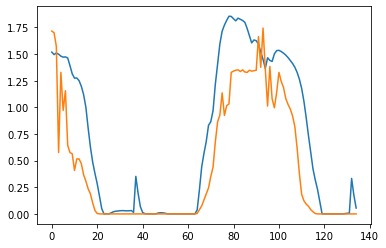

In [34]:
# 用最佳模型预测一下test
all_data_test=[]
for i in range (time_step,len(df_for_testing_scaled_forpred_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_forpred_array[i-time_step :i , 0:df_for_testing_scaled_forpred.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_forpred.iloc[i,-1]=prediction
print(ev(test_y,np.array(all_data_test)))
# 看看test的结果
plt.plot(range(len(all_data_test)), all_data_test, label='Prediction')
plt.plot(range(len(test_y)), test_y, label='turth')

C:\Users\23966\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


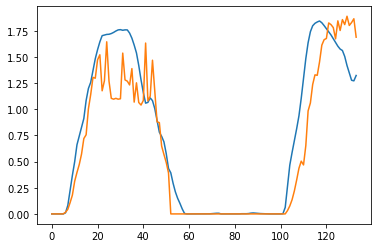

In [35]:
# 用最佳模型预测一下valid
all_data_valid=[]
for i in range (time_step,len(df_for_validing_scaled_forpred_array)) :
                 data_x=[]
                 data_x.append( df_for_validing_scaled_forpred_array[i-time_step :i , 0:df_for_validing_scaled_forpred.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_valid.append(prediction)
                 df_for_validing_scaled_forpred.iloc[i,-1]=prediction
                    # 看看valid的结果
plt.plot(range(len(all_data_valid)), all_data_valid, label='Prediction')
plt.plot(range(len(valid_y)), valid_y, label='Prediction')

16.378719048212012


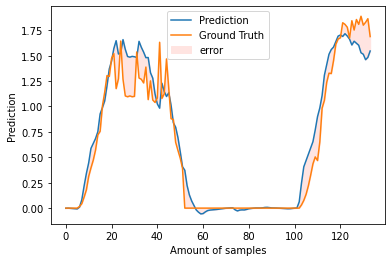

In [36]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
print(ev(valid_y,pred_valid_y))
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

22.02798972668372


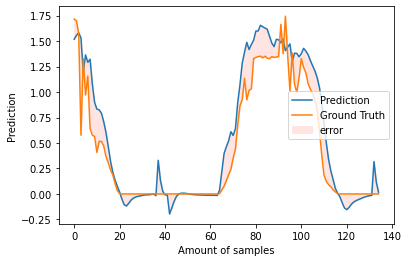

In [37]:
# 查看test集预测结果
pred_test_y = my_model.predict(test_X)
print(ev(test_y,pred_test_y))
plt.plot(range(len(pred_test_y)), pred_test_y, label='Prediction')
plt.plot(range(len(pred_test_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_test_y)), pred_test_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [38]:
gf_df_test_copy.tail(7)

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-19 22:15:00,0.0,8.9275,5.9149,27.97,996.89,91.540,0.0
2022-06-19 22:30:00,0.0,8.9770,6.4600,27.96,996.97,91.780,0.0
2022-06-19 22:45:00,0.0,8.8735,7.3813,27.97,997.04,91.880,0.0
2022-06-19 23:00:00,0.0,7.6355,357.8234,27.16,996.98,89.325,0.0
2022-06-19 23:15:00,0.0,7.0539,352.9153,27.19,997.26,89.325,0.0
2022-06-19 23:30:00,0.0,6.7206,350.5797,27.27,997.28,89.325,0.0
2022-06-19 23:45:00,0.0,7.0146,352.2164,27.27,996.74,89.325,0.0


In [39]:
dff=gf_df_test_copy.tail(time_step)
full_df_fea=dff.append(df_feaformm)
full_df_fea.to_csv('full_df_fea.csv',encoding = 'utf-8')


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\303592659.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_fea=dff.append(df_feaformm)


In [40]:
df_fea=pd.read_csv('full_df_fea.csv',index_col=[0])
df_fea=simla(df,df_fea)
df_fea

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-19 16:30:00,35.930736,1.281477,0.448554,1.045700,0.997751,0.968486,0.983803
2022-06-19 16:45:00,31.671861,1.284221,0.434999,1.041742,0.997671,0.971956,0.919830
2022-06-19 17:00:00,27.426840,1.276363,0.440242,1.038143,0.997641,0.974419,0.819836
2022-06-19 17:15:00,23.290909,1.267981,0.440640,1.034545,0.997611,0.978338,0.619842
2022-06-19 17:30:00,19.191342,1.263722,0.426803,1.030587,0.997581,0.983487,0.379894
...,...,...,...,...,...,...,...
2022-07-21 22:45:00,0.000000,0.598245,1.635199,0.996042,0.995687,0.905682,NaN
2022-07-21 23:00:00,0.000000,0.617545,1.647895,0.994962,0.996198,0.949790,NaN
2022-07-21 23:15:00,0.000000,0.518221,1.538831,0.983447,0.996419,0.949790,NaN


In [41]:
df_fea_array=df_fea.values

In [42]:
# 用最佳模型预测一下fea
all_data_fea=[]
for i in range (time_step,len(df_fea_array)) :
                 data_x=[]
                 data_x.append( df_fea_array[i-time_step :i , 0:df_fea.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_fea.append(prediction)
                 df_fea.iloc[i,-1]=prediction


C:\Users\23966\AppData\Local\Temp\ipykernel_16952\1157379746.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(range(len(all_data_fea)), np.array(all_data_fea).flatten(), label='Prediction')


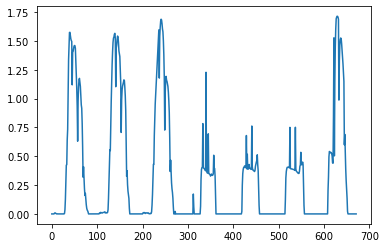

In [43]:
plt.plot(range(len(all_data_fea)), np.array(all_data_fea).flatten(), label='Prediction')

In [44]:
all_data_fea_Denormalization=Denormalization(df,pd.DataFrame(all_data_fea))


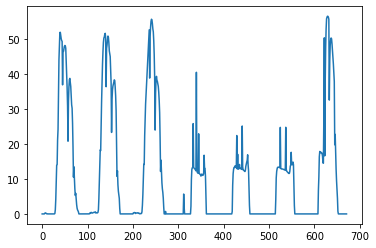

In [45]:
plt.plot(range(len(all_data_fea_Denormalization)), np.array(all_data_fea_Denormalization).flatten(), label='Prediction')

In [46]:
gf_time=pd.read_csv('.\\data\\YC_Result_GF.csv')
gf_time['Power(MW)']=all_data_fea_Denormalization.values
gf_time.to_csv('feature_gf_power.csv',index=0)